In [1]:
import os

from models.VAE import VariationalAutoencoder
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

os.listdir("data/X-ray_dataset_old/chest_xray")

Using TensorFlow backend.
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chiara/.local/lib/python3.6/site-packages/tensorflow/python

['train', 'test', 'chest_xray', 'val', '__MACOSX']

## data

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


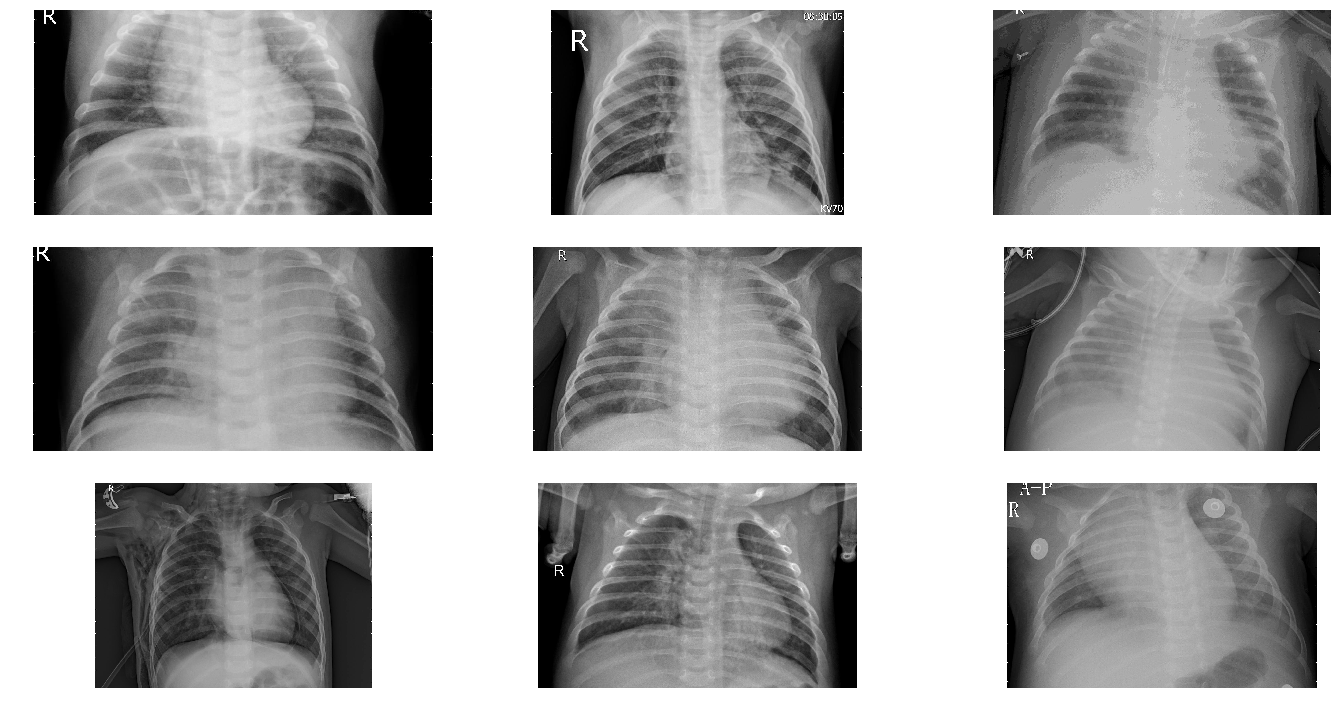

In [2]:

train_dir = "data/X-ray_dataset_old/chest_xray/train"
test_dir = "data/X-ray_dataset_old/chest_xray/test"
val_dir = "data/X-ray_dataset_old/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
NUM_IMAGES = num_pneumonia+num_normal

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("data/X-ray_dataset_old/chest_xray/train/PNEUMONIA")
pneumonia_dir = "data/X-ray_dataset_old/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()



In [3]:
INPUT_DIM = (224,224,3)
BATCH_SIZE = 32
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)
train = data_gen.flow_from_directory(train_dir, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True, 
                                            class_mode='input',
                                            subset = "training",
                                            target_size=INPUT_DIM[:2])

validation = data_gen.flow_from_directory(val_dir, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True, 
                                            class_mode='input',
                                            target_size=INPUT_DIM[:2])

test = data_gen.flow_from_directory(test_dir, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True, 
                                            class_mode='input',
                                            target_size=INPUT_DIM[:2])


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## VAE Training

In [10]:
# run params
section = 'vae'
run_id = '0006'
data_name = 'x-ray_old'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [11]:
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=20
                , use_batch_norm=True
                , use_dropout=True)
if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [12]:
vae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 112, 112, 32) 896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 112, 112, 32) 128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 112, 112, 32) 0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
dropout_8 

In [13]:
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12544)             263424    
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 28, 64)        0         
__________

In [14]:
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)


In [15]:
vae.train_with_generator(     
    train
    , epochs = EPOCHS
    , steps_per_epoch = NUM_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/200
163/163 [==============================] - 212s 1s/step - loss: 8619.7289 - vae_r_loss: 8538.1690 - vae_kl_loss: 81.5599

Epoch 00001: saving model to run/vae/0006_x-ray_old/weights/weights-001-8619.73.h5

Epoch 00001: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 2/200
163/163 [==============================] - 215s 1s/step - loss: 7066.4220 - vae_r_loss: 6983.4172 - vae_kl_loss: 83.0048

Epoch 00002: saving model to run/vae/0006_x-ray_old/weights/weights-002-7066.42.h5

Epoch 00002: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 3/200
163/163 [==============================] - 217s 1s/step - loss: 6890.3189 - vae_r_loss: 6818.0688 - vae_kl_loss: 72.2502

Epoch 00003: saving model to run/vae/0006_x-ray_old/weights/weights-003-6890.32.h5

Epoch 00003: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 4/200
163/163 [==============================] - 216s 1s/step - loss: 6831.9878 - vae_r_loss: 6765.4545 - vae_kl_loss: 66.5334


163/163 [==============================] - 216s 1s/step - loss: 6617.8299 - vae_r_loss: 6570.5184 - vae_kl_loss: 47.3114

Epoch 00057: saving model to run/vae/0006_x-ray_old/weights/weights-057-6617.83.h5

Epoch 00057: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 58/200
163/163 [==============================] - 216s 1s/step - loss: 6617.3766 - vae_r_loss: 6569.8795 - vae_kl_loss: 47.4971

Epoch 00058: saving model to run/vae/0006_x-ray_old/weights/weights-058-6617.38.h5

Epoch 00058: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 59/200
163/163 [==============================] - 216s 1s/step - loss: 6616.2661 - vae_r_loss: 6569.0797 - vae_kl_loss: 47.1864

Epoch 00059: saving model to run/vae/0006_x-ray_old/weights/weights-059-6616.27.h5

Epoch 00059: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 60/200
163/163 [==============================] - 216s 1s/step - loss: 6622.8024 - vae_r_loss: 6575.6120 - vae_kl_loss: 47.1905

Epoch 00

163/163 [==============================] - 215s 1s/step - loss: 6600.7255 - vae_r_loss: 6553.1824 - vae_kl_loss: 47.5431

Epoch 00113: saving model to run/vae/0006_x-ray_old/weights/weights-113-6600.73.h5

Epoch 00113: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 114/200
163/163 [==============================] - 215s 1s/step - loss: 6596.0928 - vae_r_loss: 6548.5036 - vae_kl_loss: 47.5892

Epoch 00114: saving model to run/vae/0006_x-ray_old/weights/weights-114-6596.09.h5

Epoch 00114: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 115/200
163/163 [==============================] - 216s 1s/step - loss: 6603.3566 - vae_r_loss: 6555.6172 - vae_kl_loss: 47.7394

Epoch 00115: saving model to run/vae/0006_x-ray_old/weights/weights-115-6603.36.h5

Epoch 00115: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 116/200
163/163 [==============================] - 216s 1s/step - loss: 6599.0748 - vae_r_loss: 6551.4515 - vae_kl_loss: 47.6233

Epoch

163/163 [==============================] - 216s 1s/step - loss: 6595.3817 - vae_r_loss: 6547.6413 - vae_kl_loss: 47.7404

Epoch 00169: saving model to run/vae/0006_x-ray_old/weights/weights-169-6595.38.h5

Epoch 00169: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 170/200
163/163 [==============================] - 215s 1s/step - loss: 6592.6179 - vae_r_loss: 6544.9867 - vae_kl_loss: 47.6312

Epoch 00170: saving model to run/vae/0006_x-ray_old/weights/weights-170-6592.62.h5

Epoch 00170: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 171/200
163/163 [==============================] - 215s 1s/step - loss: 6595.9776 - vae_r_loss: 6548.1590 - vae_kl_loss: 47.8186

Epoch 00171: saving model to run/vae/0006_x-ray_old/weights/weights-171-6595.98.h5

Epoch 00171: saving model to run/vae/0006_x-ray_old/weights/weights.h5
Epoch 172/200
163/163 [==============================] - 216s 1s/step - loss: 6595.3551 - vae_r_loss: 6547.4493 - vae_kl_loss: 47.9058

Epoch